# Model selection

In [10]:
using Revise

In [11]:
using RxInfer, Distributions, Random, PyPlot, LinearAlgebra

### Data generation

In [20]:
# specify distribution
component1 = MvNormalMeanPrecision([3 .* sin(0), 3 .* cos(0)], diagm(ones(2)))
component2 = MvNormalMeanPrecision([3 .* sin(2*2*pi/3), 3 .* cos(2*2*pi/3)], diagm(ones(2)))
component3 = MvNormalMeanPrecision([3 .* sin(4*2*pi/3), 3 .* cos(4*2*pi/3)], diagm(ones(2)))
dist = MixtureModel([component1, component2, component3], [0.2, 0.5, 0.3]);

In [21]:
function generate_data(dist, nr_samples; rng=MersenneTwister(123))

    # sample from distribution
    samples = rand(rng, dist, nr_samples)

    # return samples
    return samples

end;

In [22]:
data = generate_data(dist, 100);

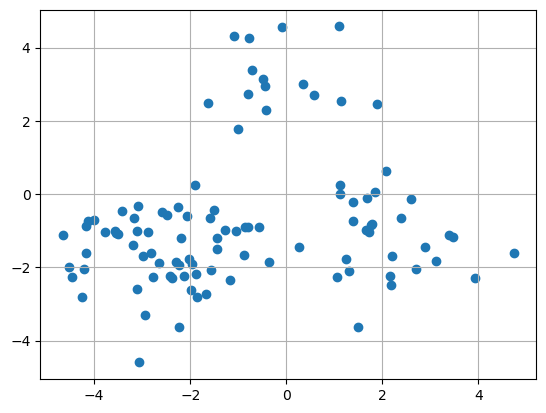

In [23]:
# plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
# plt.hist(data, density="relative", bins=200, alpha=0.5)
# plt.plot(-5:0.01:5, map(x -> dist.weights[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
# plt.plot(-5:0.01:5, map(x -> dist.weights[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
# plt.plot(-5:0.01:5, map(x -> dist.weights[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
# plt.scatter(data, 0.24*ones(length(data)))
plt.scatter(data[1,:], data[2,:])
plt.grid()
# plt.xlim(-5, 5)
# plt.ylim(0, 0.25)

In [32]:
@model function model_selection(nr_samples)

    # specify experimental outcomes
    y = datavar(Vector{Float64}, nr_samples)
    θ = randomvar(nr_samples)
    θ1 = randomvar(nr_samples)
    θ2 = randomvar(nr_samples)
    θ3 = randomvar(nr_samples)
    z = randomvar(nr_samples)

    # create likelihood models
    for i in 1:nr_samples

        # specify John's and Jane's prior models over θ
        θ1[i] ~ MvNormalMeanPrecision([3 .* sin(0*2*pi/3), 3 .* cos(0*2*pi/3)], 100 .*diagm(ones(2)))
        θ2[i] ~ MvNormalMeanPrecision([3 .* sin(2*2*pi/3), 3 .* cos(2*2*pi/3)], 100 .*diagm(ones(2)))
        θ3[i] ~ MvNormalMeanPrecision([3 .* sin(4*2*pi/3), 3 .* cos(4*2*pi/3)], 100 .*diagm(ones(2)))

        # specify initial guess as to who is right
        z[i] ~ Categorical([0.2, 0.5, 0.3])

        # specify mixture prior Distribution
        θ[i] ~ Mixture(z[i], (θ1[i], θ2[i], θ3[i])) where { pipeline = RequireMarginal(switch) }

        # specify observatio noise
        y[i] ~ MvNormalMeanPrecision(θ[i], diagm(ones(2)))
        
    end

    return y, θ, θ1, θ2, θ3, z

end

In [33]:
@constraints function constraints_selection()
    q(z) :: PointMass
end

constraints_selection (generic function with 1 method)

In [34]:
data_y = [data[:,i] for i in 1:size(data,2)]
results_selection = inference(
    model = model_selection(100),
    constraints = constraints_selection(),
    data  = (y = data_y, ),
    returnvars = (θ = KeepLast(), θ1 = KeepLast(), θ2 = KeepLast(), θ3 = KeepLast(), z=KeepLast()),
    options = ( addons = (AddonLogScale(),), )
)

Inference results:
  Posteriors       | available for (θ1, θ3, θ2, z, θ)


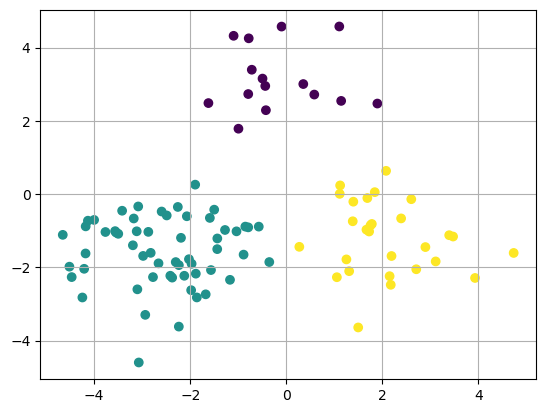

In [38]:
plt.scatter(data[1,:], data[2,:], c=argmax.(mean.(results_selection.posteriors[:z])))
plt.grid()


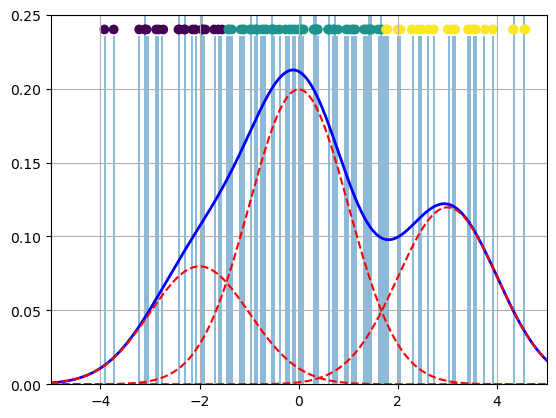

(0.0, 0.25)

┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147", ArgumentError("invalid type for argument s in method definition for size at C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147"), Any[(top-level scope at Compat.jl:147, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000002688b1fe])
└ @ Revise C:\Users\s151781\.julia\packages\Revise\do2nH\src\pkgs.jl:477
┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147", ArgumentError("invalid type for argument s in method definition for size at C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147"), Any[(top-level scope at Compat.jl:147, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000002688b1fe])
└ @ Revise C:\Users\s151781\.julia\packages\Revise\do2nH\src\pkgs.jl:477


In [ ]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.scatter(data, 0.24*ones(length(data)), c=argmax.(mean.(results_selection.posteriors[:z])))
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)